# Image Clustering Using Gaussian Mixture Models with EM

In this project I will
* implement the EM algorithm for a Gaussian mixture model
* apply the implementation to cluster images
* explore clustering results and interpret the output of the EM algorithm  

## Import necessary packages

The following code block check for the correct version of GraphLab Create. Any version later than 1.8.5 will do.

In [2]:
import graphlab as gl
import numpy as np
import matplotlib.pyplot as plt 
import copy
from scipy.stats import multivariate_normal

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(gl.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

## Implementing the EM algorithm for Gaussian mixture models

### Log likelihood 
The below function calculates log likelihood for mixture of Gaussians. The log likelihood quantifies the probability of observing a given set of data under a particular setting of the parameters in our model. I will use this to assess convergence of the EM algorithm; specifically, I will keep looping through EM update steps until the log likehood ceases to increase at a certain rate.

In [6]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

### Implementation of the EM algorithm

Here is an implementation that can run EM on the image data. It uses the `loglikelihood` function provided above.

In [3]:
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for i in range(maxiter):
        if i % 5 == 0:
            print("Iteration %s" % i)
        
        # E-step: compute responsibilities
        # Update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j.
        # Hint: To compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf.
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k] * multivariate_normal.pdf(data[j],means[k],covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # normalize over all possible cluster assignments

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = np.sum(resp, axis=0)
        
        for k in range(num_clusters):
            
            # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
            weights[k] = counts[k]/num_data
            
            # Update means for cluster k using the M-step update rule for the mean variables.
            # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += resp[j,k] *data[j]
            means[k] = 1/counts[k]*weighted_sum
            
            # Update covariances for cluster k using the M-step update rule for covariance variables.
            # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
            weighted_sum = np.zeros((num_dim, num_dim))
            for j in range(num_data):
                weighted_sum += resp[j,k]*(np.outer(data[j] - means[k], data[j] - means[k]))
            covariances[k] = weighted_sum /counts[k]
          
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if i % 5 != 0:
        print("Iteration %s" % i)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

## Fitting a Gaussian mixture model for image data

Now I will apply the implemented EM algorithm to cluster some more interesting data. In particular, I have a set of images that come from four categories: sunsets, rivers, trees and forests, and cloudy skies. For each image the dataset provides the average intensity of its red, green, and blue pixels, so we have a 3-dimensional representation of our data. My goal is to find a good clustering of these images using our EM implementation; ideally our algorithm would find clusters that roughly correspond to the four image categories.

The image data is provided in SFrame format:

In [4]:
images = gl.SFrame('images.sf')
gl.canvas.set_target('ipynb')
import array
images['rgb'] = images.pack_columns(['red', 'green', 'blue'])['X4']
images.show()

I need to come up with initial estimates for the mixture weights and component parameters. I will take three images to be the initial cluster centers, and then initialize the covariance matrix of each cluster to be diagonal with each element equal to the sample variance from the full data. I will start by assuming each mixture component has equal weight. 

In [7]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 118


The following sections will evaluate the results by asking the following questions:

* **Convergence**: How did the log likelihood change across iterations? Did the algorithm achieve convergence?
* **Uncertainty**: How did cluster assignment and uncertainty evolve?
* **Interpretability**: Can we view some example images from each cluster? Do these clusters correspond to known image categories?

### Evaluating convergence

I plot the log likelihood at each iteration - the EM algorithm guarantees that the log likelihood can only increase (or stay the same) after each iteration, so the plot should show an increasing function.

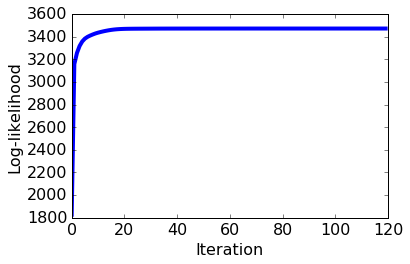

In [8]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

The log likelihood increases so quickly on the first few iterations that we can barely see the plotted line. Let's plot the log likelihood after the first three iterations to get a clearer view of what's going on:

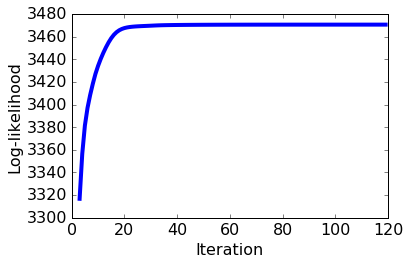

In [9]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

### Evaluating uncertainty

Next I will explore the evolution of cluster assignment and uncertainty. The EM algorithm represents uncertainty about the cluster assignment of each data point through the responsibility matrix. Rather than making a 'hard' assignment of each data point to a single cluster, the algorithm computes the responsibility of each cluster for each data point, where the responsibility corresponds to our certainty that the observation came from that cluster. 

I will track the evolution of the responsibilities across iterations to see how these 'soft' cluster assignments change as the algorithm fits the Gaussian mixture model to the data; for that, I will plot the data and color each point according to its cluster responsibilities. The data are three-dimensional, which can make visualization difficult, so to make things easier I will plot the data using only two dimensions, taking just the [R G], [G B] or [R B] values instead of the full [R G B] measurement for each observation.


In [10]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    G = img['green']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()
    
def plot_responsibilities_in_RG(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    G = img['green']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], G[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('G value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()
    
def plot_responsibilities_in_GB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    
    R = img['red']
    G = img['green']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [tuple(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(N)]

    plt.figure()
    for n in range(len(R)):
        plt.plot(G[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('G value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

To begin, I visualize what happens when each data has random responsibilities.

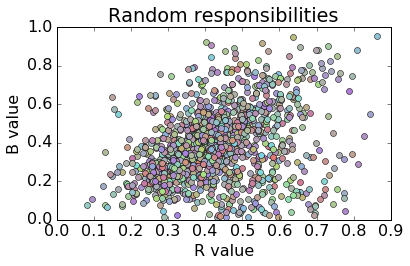

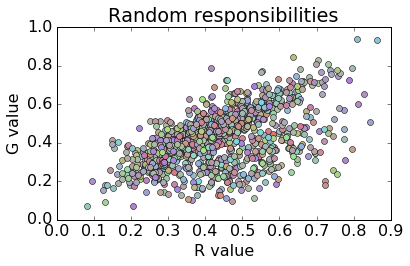

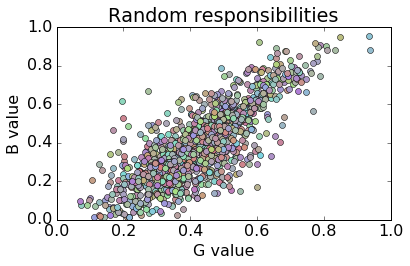

In [12]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')
plot_responsibilities_in_RG(images, random_resp, 'Random responsibilities')
plot_responsibilities_in_GB(images, random_resp, 'Random responsibilities')

I now use the above plotting function to visualize the responsibilites after 1 iteration. 

Iteration 0


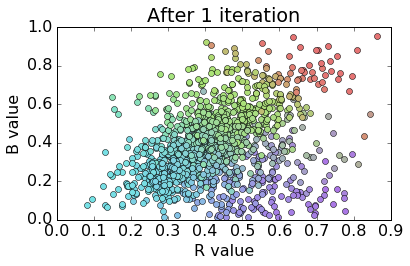

In [13]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out['resp'], 'After 1 iteration')

Now, I visualize the responsibilites after 20 iterations. There are fewer unique colors after 20 iterations; this indicates that there is more certainty that each point belongs to one of the four components in the model. 

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


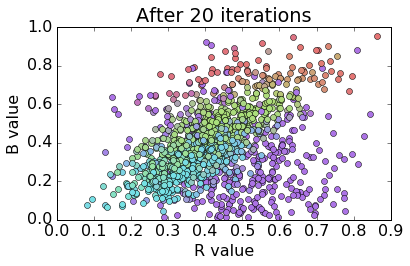

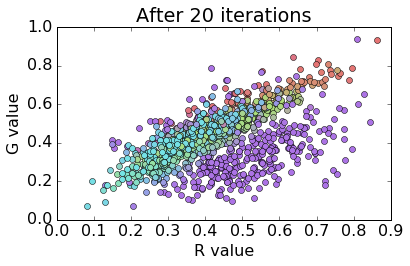

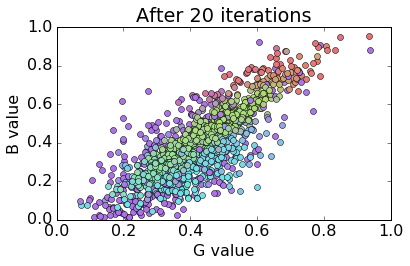

In [14]:
out = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out['resp'], 'After 20 iterations')
plot_responsibilities_in_RG(images, out['resp'], 'After 20 iterations')
plot_responsibilities_in_GB(images, out['resp'], 'After 20 iterations')

Plotting the responsibilities over time in [R B] space shows a meaningful change in cluster assignments over the course of the algorithm's execution. While the clusters look significantly better organized at the end of the algorithm than they did at the start, it appears from the plots that they are still not very well separated. This is due in part to the decision to plot 3D data in a 2D space; everything that was separated along the G axis is now "squashed" down onto the flat [R B] plane. If I was to plot the data in full [R G B] space, then I would expect to see further separation of the final clusters.

### Interpreting each cluster

Let's dig into the clusters obtained from our EM implementation. I can evaluate the quality of the clustering by taking a look at a few images that 'belong' to each cluster. I hope to find that the clusters discovered by the EM algorithm correspond to different image categories - in this case, I know that the images came from four categories ('cloudy sky', 'rivers', 'sunsets', and 'trees and forests'), so I would expect to find that each component of the fitted mixture model roughly corresponds to one of these categories.

First, I need to consider how to determine cluster assignments of the images from the algorithm output. This would be easy with k-means - every data point had a 'hard' assignment to a single cluster, and all one need to do is to find the cluster center closest to the data point of interest. In my case, the clusters are described by probability distributions (specifically, Gaussians) rather than single points, and the model maintains some uncertainty about the cluster assignment of each observation.

One way to phrase the question of cluster assignment for mixture models is as follows: how to calculate the distance of a point from a distribution? Simple Euclidean distance might not be appropriate since (non-scaled) Euclidean distance doesn't take direction into account.  For example, if a Gaussian mixture component is very stretched in one direction but narrow in another, then a data point one unit away along the 'stretched' dimension has much higher probability (and so would be thought of as closer) than a data point one unit away along the 'narrow' dimension. 

In this case, I use a [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance). For a Gaussian distribution, this distance is proportional to the square root of the negative log likelihood. This makes sense intuitively - reducing the Mahalanobis distance of an observation from a cluster is equivalent to increasing that observation's probability according to the Gaussian that is used to represent the cluster. This also means that I can find the cluster assignment of an observation by taking the Gaussian component for which that observation scores highest. I will use this fact to find the top examples that are 'closest' to each cluster.

I calculate cluster assignments for the entire image dataset using the result of running EM for 20 iterations above:

In [15]:
means = out['means']
covariances = out['covs']
rgb = images['rgb']
N = len(images)
K = len(means)

assignments = [0]*N
probs = [0]*N

for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    p = np.zeros(K)
    for k in range(K):
        p[k] = multivariate_normal.pdf(rgb[i],means[k],covariances[k]) * out['weights'][k]
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment:
    probs[i] = np.max(p)

assignments = gl.SFrame({'assignments':assignments, 'probs':probs, 'image': images['image']})

In [16]:
assignments

assignments,probs,image
3,5.86281349859,Height: 194 Width: 259
3,2.86757162031,Height: 194 Width: 259
3,1.0278573275,Height: 183 Width: 275
3,0.00202755556422,Height: 183 Width: 276
3,3.87914151135,Height: 177 Width: 284
3,8.96121569127,Height: 177 Width: 284
3,3.14531378935,Height: 194 Width: 259
3,3.63236959615,Height: 183 Width: 275
3,4.12839193535,Height: 275 Width: 183
1,18.3230531435,Height: 183 Width: 275


I will use the 'assignments' SFrame to find the top images from each cluster by sorting the datapoints within each cluster by their score under that cluster (stored in `probs`).

In [18]:
def get_top_images(assignments, cluster, k=5):
    images_in_cluster = assignments[assignments['assignments']==cluster]
    top_images = images_in_cluster.topk('probs', k)
    return top_images['image']

Finally, I use this function to show the top 5 images in each cluster.

In [19]:
gl.canvas.set_target('ipynb')
for component_id in range(4):
    get_top_images(assignments, component_id).show()

The algorithm seems to have done a good job overall at 'discovering' the four categories from which the image data was drawn. 

It seems to have had the most difficulty in distinguishing between rivers and cloudy skies, probably due to the similar color profiles of images in these categories; if I wanted to achieve better performance on distinguishing between these categories, I might need a richer representation of the data than simply the average [R G B] values for each image.